#### Import and ENV

In [1]:
import torch.nn as nn
import torch
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torchmetrics import Accuracy
import importlib
# Local files
import data
importlib.reload(data)
import encoder
importlib.reload(encoder)
import decoder
importlib.reload(decoder)
import autoencoder
importlib.reload(autoencoder)
import training
importlib.reload(training)
import main
importlib.reload(main)
import VAE
importlib.reload(VAE)
import training_VAE
importlib.reload(training_VAE)
# Random Seed
torch.manual_seed(0)

In [2]:
# bsn = [8,16,32,64,128]
# for i in bsn: 
#     main.main(bottle_neck = i, experiment_type=3)
#     print(f"Done bottle size: {i}")

In [3]:
torch.cuda.is_available()

True

## **DataLoader**

In [4]:
# from data import get_datasets,dataset_to_dataloader
train_ds, val_ds, test_ds = data.get_datasets()
dataloader_train = data.dataset_to_dataloader(train_ds)
dataloader_test = data.dataset_to_dataloader(test_ds)
dataloader_val = data.dataset_to_dataloader(val_ds)

Files already downloaded and verified
Files already downloaded and verified


## **AutoEncoder Model**

## **Training** 

In [5]:
z_dim = 512
latent_dim = 128
encoder_ = encoder.resnet18(pretrained=False,num_classes=z_dim)
decoder_ = decoder.ResNet18Dec(z_dim=latent_dim)
model = VAE.VAE(encoder_,decoder_,z_dim,latent_dim).to(torch.device('cuda:0'))

In [6]:
optimizer = torch.optim.Adam(model.parameters())
model, history = training_VAE.train(
    model,
    optimizer,
    dataloader_train,
    dataloader_val,
    save_file_name='VAE.pt',
    max_epochs_stop=5,
    n_epochs=2,
    print_every=2)

print(history)
history.to_csv('VAE_History.csv')

Starting Training from Scratch.

Epoch: 1	100.00% complete. 144.50 seconds elapsed in epoch.
Epoch: 1 	Training Loss: -4488850.1314 	Validation Loss: -4783745.5492

Best epoch: 1 with loss: -4783745.55
298.41 total seconds elapsed. 298.41 seconds per epoch.
     train_loss    valid_loss        time
0 -3.187610e+06 -3.813418e+06  149.693950
1 -4.488850e+06 -4.783746e+06  148.405207


In [7]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [11]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        with torch.no_grad():
          for t, m, s in zip(tensor, self.mean, self.std):
              t.mul_(s).add_(m)
              # The normalize code -> t.sub_(m).div_(s)
          return tensor

In [22]:
from torchvision.utils import make_grid
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))

def peek_results(dataloader, model):
  for img,lb in dataloader:
    fig, ax = plt.subplots(figsize=(16,8))
    fig1, ax1 = plt.subplots(figsize=(16,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax1.set_xticks([]); ax1.set_yticks([])
    img_output,_,_ = model(img.cuda())
    img_output = img_output.cpu()
    print(img_output.size())
    ax.imshow(make_grid(unorm(img_output), nrow=16).permute(1,2,0))
    ax1.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])


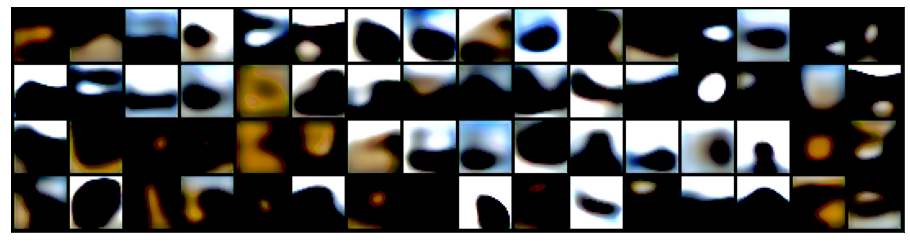

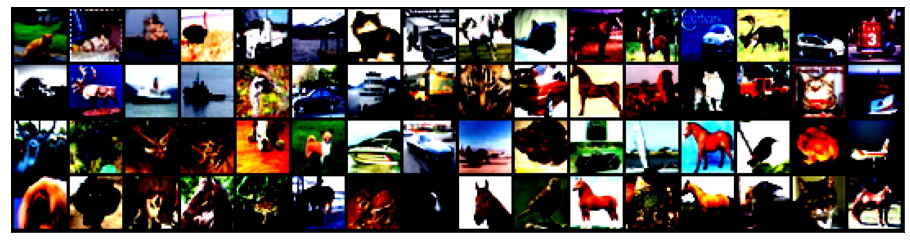

In [23]:
peek_results(dataloader_test, model)